<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>13. Whole population light gbm classifier OPTUNA</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Eliminación de valores nulos](#23)<br>
    2.4. [Binarización de variable delta_WHP](#24)<br>
    2.5. [Separación en train y test](#25)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Optimización de hiperparámetros](#32)<br>
    3.3. [Entrenamiento del modelo](#33)<br>
    3.4. [Mejores Hiperparámetros](#34)<br>
4. [Evaluación del modelo](#4)<br>
    4.1. [Cálculo de métricas](#41)<br>
    4.2. [Matriz de confusión](#42)<br>
    4.3. [ROC Curve](#43)<br>
    4.4. [Precision-Recall curve](#44)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [92]:
! pip install optuna
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, plot_precision_recall_curve, make_scorer, fbeta_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier
import optuna

import chardet

import warnings
warnings.filterwarnings("ignore")

In [94]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [95]:
# Detección automática de la codificación de los caracteres
with open("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
23979,Pozo 122-Pozo 127-10,Campo C,GAS,PAD-19,Pozo 122,10,Pozo 127,690.589415,690.269942,-21.003525,264.103394,0.0,NO,331.6,0.0,Cerrado
17144,Pozo 548-Pozo 209-19,Campo E,OIL,PAD-84,Pozo 548,19,Pozo 209,1527.298020,1527.205637,16.798379,2.401948,0.0,NO,0.0,0.0,Cerrado
21562,Pozo 486-Pozo 91-17,Campo C,GAS,PAD-26,Pozo 486,17,Pozo 91,537.293871,535.426956,44.751292,256.211804,1.0,NO,186.8,0.0,Cerrado
16934,Pozo 132-Pozo 124-13,Campo C,GAS,PAD-19,Pozo 132,13,Pozo 124,862.364949,861.188112,-45.037107,269.118491,5.0,NO,434.3,0.0,Abierto
5068,Pozo 401-Pozo 218-11,Campo E,OIL,PAD-58,Pozo 401,11,Pozo 218,1396.361380,1396.354666,-4.330291,101.048120,2.0,NO,42.1,0.0,Abierto


In [96]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS      float64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="23"></a> <br>
### 2.3. Eliminación de valores nulos
**Dado que el modelo a desarrollar en el presente notebook será tomado como baseline, se eliminan los valores nulos para mayor practicidad**

In [97]:
print("Cantidad de instancias totales =", df.shape[0])
# Eliminación de todos los valores nulos de dataset
df.dropna(inplace=True)
print("Cantidad de instancias sin valores nulos =", df.shape[0])

Cantidad de instancias totales = 26178
Cantidad de instancias sin valores nulos = 26178


<a id="24"></a> <br>
### 2.4. Binarización de variable delta_WHP

In [98]:
# Se crea una nueva variable en donde se asigna valor 0 cuando delta_WHP = 0 y valor 1 cuando delta_WHP != 0
df["delta_WHP_binarized"] = df["delta_WHP"].apply(lambda val: 1 if val != 0 else 0)

<a id="25"></a> <br>
### 2.5. Separación en train y test

In [99]:
# Selección de variable target
y = df.delta_WHP_binarized
# Selección de features
X = df.drop(["delta_WHP_binarized"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  stratify= y, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train.shape[0])
print("Instancias de test \n", X_test.shape[0])

Instancias de train 
 19633
Instancias de test 
 6545


***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Confección pipeline

<a id="32"></a> <br>
### 3.2. Optimización de hiperparámetros

In [100]:
# Creacion de score f2 
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [101]:
# Función objetivo de optuna

def objective_pipe(trial):

  params = {
          'random_state': 48,
          'learning_rate': trial.suggest_float('learning_rate_catboost', 0.01,1),
          'n_estimators' : trial.suggest_int('n_estimators_catboost', 5, 500),
          'max_depth' : trial.suggest_int('max_depth_catboost', 5, 15),
          'l2_leaf_reg': trial.suggest_int('l2_leaf_reg_catboost', 1, 100)
      }

  catboost = CatBoostClassifier(**params)

  # Instanciado de pipeline
  pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO", "delta_WHP"])),
                    
                    ("column_transformer",ColumnTransformer([
                                          ("standard_scaler", StandardScaler(), 
                      ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                  
                                  ("catboost", catboost)])

   
  # Cross validation
  kfold = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)    
    
  # Return
  return cross_val_score(pipe, X_train, y_train, cv= kfold, scoring= ftwo_scorer).mean()


In [ ]:
%%time
models=[]
scores=[]
pipe_study = optuna.create_study(direction='maximize')
pipe_study.optimize(objective_pipe, n_trials=20)
model='catboost'
score=pipe_study.best_trial.value
models.append(model)
scores.append(score)

[I 2022-11-07 19:22:32,266] A new study created in memory with name: no-name-9059ac57-9ab4-42c8-bfc2-9224c0db49a9


0:	learn: 0.4761257	total: 1.4s	remaining: 9m 55s
1:	learn: 0.3424100	total: 1.41s	remaining: 4m 59s
2:	learn: 0.2921421	total: 2.79s	remaining: 6m 34s
3:	learn: 0.2589273	total: 4s	remaining: 7m 3s
4:	learn: 0.2366219	total: 5.31s	remaining: 7m 28s
5:	learn: 0.2237624	total: 7.35s	remaining: 8m 35s
6:	learn: 0.2109943	total: 9.35s	remaining: 9m 21s
7:	learn: 0.2051891	total: 11.2s	remaining: 9m 48s
8:	learn: 0.2003613	total: 13.5s	remaining: 10m 25s
9:	learn: 0.1951371	total: 15.5s	remaining: 10m 47s
10:	learn: 0.1893261	total: 17.5s	remaining: 11m 1s
11:	learn: 0.1856885	total: 19.4s	remaining: 11m 9s
12:	learn: 0.1826281	total: 21.5s	remaining: 11m 24s
13:	learn: 0.1794915	total: 23.6s	remaining: 11m 36s
14:	learn: 0.1764549	total: 25.9s	remaining: 11m 51s
15:	learn: 0.1736089	total: 28s	remaining: 12m
16:	learn: 0.1711384	total: 30.2s	remaining: 12m 7s
17:	learn: 0.1690055	total: 32.5s	remaining: 12m 18s
18:	learn: 0.1669148	total: 34.7s	remaining: 12m 25s
19:	learn: 0.1647794	tota

[I 2022-11-07 19:48:19,065] Trial 0 finished with value: 0.6972200913770704 and parameters: {'learning_rate_catboost': 0.23313293679932734, 'n_estimators_catboost': 427, 'max_depth_catboost': 15, 'l2_leaf_reg_catboost': 58}. Best is trial 0 with value: 0.6972200913770704.


0:	learn: 0.3479145	total: 16.9ms	remaining: 2.1s
1:	learn: 0.2720345	total: 28.8ms	remaining: 1.77s
2:	learn: 0.2335891	total: 40.6ms	remaining: 1.65s
3:	learn: 0.2179266	total: 52.3ms	remaining: 1.58s
4:	learn: 0.2092023	total: 63.9ms	remaining: 1.53s
5:	learn: 0.2015121	total: 76.2ms	remaining: 1.51s
6:	learn: 0.1969073	total: 87.8ms	remaining: 1.48s
7:	learn: 0.1921392	total: 99.8ms	remaining: 1.46s
8:	learn: 0.1884602	total: 111ms	remaining: 1.44s
9:	learn: 0.1860274	total: 123ms	remaining: 1.41s
10:	learn: 0.1838733	total: 134ms	remaining: 1.39s
11:	learn: 0.1824091	total: 146ms	remaining: 1.38s
12:	learn: 0.1805028	total: 158ms	remaining: 1.36s
13:	learn: 0.1786482	total: 169ms	remaining: 1.34s
14:	learn: 0.1773209	total: 181ms	remaining: 1.33s
15:	learn: 0.1766526	total: 192ms	remaining: 1.31s
16:	learn: 0.1755020	total: 207ms	remaining: 1.32s
17:	learn: 0.1736679	total: 224ms	remaining: 1.33s
18:	learn: 0.1721562	total: 236ms	remaining: 1.32s
19:	learn: 0.1714280	total: 248ms	

[I 2022-11-07 19:48:24,104] Trial 1 finished with value: 0.6601853794164715 and parameters: {'learning_rate_catboost': 0.8131953254306401, 'n_estimators_catboost': 125, 'max_depth_catboost': 9, 'l2_leaf_reg_catboost': 25}. Best is trial 0 with value: 0.6972200913770704.


120:	learn: 0.1346074	total: 1.54s	remaining: 50.9ms
121:	learn: 0.1344593	total: 1.55s	remaining: 38.2ms
122:	learn: 0.1343357	total: 1.56s	remaining: 25.4ms
123:	learn: 0.1342424	total: 1.57s	remaining: 12.7ms
124:	learn: 0.1339715	total: 1.59s	remaining: 0us
0:	learn: 0.3129566	total: 6.3ms	remaining: 1.27s
1:	learn: 0.2392506	total: 12.9ms	remaining: 1.29s
2:	learn: 0.2162357	total: 19.1ms	remaining: 1.27s
3:	learn: 0.2054848	total: 25.2ms	remaining: 1.25s
4:	learn: 0.1990331	total: 31.3ms	remaining: 1.23s
5:	learn: 0.1952701	total: 38.2ms	remaining: 1.25s
6:	learn: 0.1922361	total: 46ms	remaining: 1.28s
7:	learn: 0.1898136	total: 52.8ms	remaining: 1.28s
8:	learn: 0.1875333	total: 59.4ms	remaining: 1.27s
9:	learn: 0.1856547	total: 66.2ms	remaining: 1.27s
10:	learn: 0.1844736	total: 76.7ms	remaining: 1.33s
11:	learn: 0.1822861	total: 83.5ms	remaining: 1.32s
12:	learn: 0.1805418	total: 89.6ms	remaining: 1.3s
13:	learn: 0.1785823	total: 99.7ms	remaining: 1.34s
14:	learn: 0.1772811	tot

[I 2022-11-07 19:48:28,569] Trial 2 finished with value: 0.6756767818378258 and parameters: {'learning_rate_catboost': 0.48165918489273374, 'n_estimators_catboost': 202, 'max_depth_catboost': 6, 'l2_leaf_reg_catboost': 30}. Best is trial 0 with value: 0.6972200913770704.


188:	learn: 0.1003314	total: 1.25s	remaining: 85.9ms
189:	learn: 0.0998171	total: 1.26s	remaining: 79.9ms
190:	learn: 0.0996303	total: 1.27s	remaining: 73.2ms
191:	learn: 0.0995716	total: 1.28s	remaining: 66.6ms
192:	learn: 0.0995614	total: 1.28s	remaining: 59.9ms
193:	learn: 0.0995103	total: 1.29s	remaining: 53.2ms
194:	learn: 0.0994330	total: 1.3s	remaining: 46.5ms
195:	learn: 0.0993794	total: 1.3s	remaining: 39.9ms
196:	learn: 0.0988174	total: 1.31s	remaining: 33.2ms
197:	learn: 0.0985043	total: 1.31s	remaining: 26.6ms
198:	learn: 0.0983177	total: 1.32s	remaining: 19.9ms
199:	learn: 0.0980994	total: 1.33s	remaining: 13.3ms
200:	learn: 0.0978718	total: 1.33s	remaining: 6.63ms
201:	learn: 0.0978591	total: 1.34s	remaining: 0us
0:	learn: 0.5619640	total: 397ms	remaining: 43.7s
1:	learn: 0.4658652	total: 432ms	remaining: 23.5s
2:	learn: 0.4267986	total: 814ms	remaining: 29.3s
3:	learn: 0.3958416	total: 1.21s	remaining: 32.4s
4:	learn: 0.3688961	total: 1.61s	remaining: 34.1s
5:	learn: 0.3

[I 2022-11-07 19:50:38,124] Trial 3 finished with value: 0.6464421085643149 and parameters: {'learning_rate_catboost': 0.33678018269263066, 'n_estimators_catboost': 111, 'max_depth_catboost': 14, 'l2_leaf_reg_catboost': 61}. Best is trial 0 with value: 0.6972200913770704.


110:	learn: 0.1626248	total: 43.2s	remaining: 0us
0:	learn: 0.5117099	total: 885ms	remaining: 13.3s
1:	learn: 0.3906496	total: 897ms	remaining: 6.28s
2:	learn: 0.3424149	total: 1.76s	remaining: 7.63s
3:	learn: 0.3078635	total: 2.64s	remaining: 7.92s
4:	learn: 0.2865896	total: 3.51s	remaining: 7.73s
5:	learn: 0.2627394	total: 3.58s	remaining: 5.97s
6:	learn: 0.2509802	total: 4.46s	remaining: 5.73s
7:	learn: 0.2379720	total: 5.34s	remaining: 5.34s
8:	learn: 0.2306871	total: 6.23s	remaining: 4.85s
9:	learn: 0.2230563	total: 7.11s	remaining: 4.26s
10:	learn: 0.2196249	total: 7.99s	remaining: 3.63s
11:	learn: 0.2158584	total: 8.86s	remaining: 2.95s
12:	learn: 0.2126976	total: 9.75s	remaining: 2.25s
13:	learn: 0.2104897	total: 10.6s	remaining: 1.52s
14:	learn: 0.2068315	total: 11.5s	remaining: 767ms
15:	learn: 0.2042849	total: 12.4s	remaining: 0us
0:	learn: 0.5456101	total: 897ms	remaining: 13.5s
1:	learn: 0.4020663	total: 908ms	remaining: 6.36s
2:	learn: 0.3496821	total: 1.79s	remaining: 7.

[I 2022-11-07 19:51:13,964] Trial 4 finished with value: 0.6248398311504627 and parameters: {'learning_rate_catboost': 0.4537345456909104, 'n_estimators_catboost': 16, 'max_depth_catboost': 15, 'l2_leaf_reg_catboost': 41}. Best is trial 0 with value: 0.6972200913770704.


15:	learn: 0.2207905	total: 12.5s	remaining: 0us
0:	learn: 0.5292010	total: 68.5ms	remaining: 7.26s
1:	learn: 0.4366890	total: 86.9ms	remaining: 4.56s
2:	learn: 0.3796752	total: 159ms	remaining: 5.52s
3:	learn: 0.3370630	total: 232ms	remaining: 5.97s
4:	learn: 0.3093883	total: 303ms	remaining: 6.18s
5:	learn: 0.2933006	total: 378ms	remaining: 6.37s
6:	learn: 0.2745941	total: 446ms	remaining: 6.37s
7:	learn: 0.2611554	total: 513ms	remaining: 6.35s
8:	learn: 0.2519954	total: 599ms	remaining: 6.52s
9:	learn: 0.2423271	total: 668ms	remaining: 6.48s
10:	learn: 0.2366664	total: 736ms	remaining: 6.42s
11:	learn: 0.2297103	total: 811ms	remaining: 6.42s
12:	learn: 0.2251442	total: 880ms	remaining: 6.36s
13:	learn: 0.2196279	total: 946ms	remaining: 6.29s
14:	learn: 0.2157770	total: 1.02s	remaining: 6.25s
15:	learn: 0.2115966	total: 1.1s	remaining: 6.25s
16:	learn: 0.2089552	total: 1.17s	remaining: 6.2s
17:	learn: 0.2065342	total: 1.25s	remaining: 6.2s
18:	learn: 0.2042993	total: 1.33s	remaining:

[I 2022-11-07 19:51:39,402] Trial 5 finished with value: 0.6524130484116163 and parameters: {'learning_rate_catboost': 0.3410004559057564, 'n_estimators_catboost': 107, 'max_depth_catboost': 12, 'l2_leaf_reg_catboost': 42}. Best is trial 0 with value: 0.6972200913770704.


0:	learn: 0.2576067	total: 5.86ms	remaining: 2.48s
1:	learn: 0.2262184	total: 11.9ms	remaining: 2.52s
2:	learn: 0.2094845	total: 18.5ms	remaining: 2.6s
3:	learn: 0.2048205	total: 24.3ms	remaining: 2.56s
4:	learn: 0.1981897	total: 30.3ms	remaining: 2.55s
5:	learn: 0.1950343	total: 36.6ms	remaining: 2.56s
6:	learn: 0.1921170	total: 42.8ms	remaining: 2.55s
7:	learn: 0.1885607	total: 49ms	remaining: 2.55s
8:	learn: 0.1846614	total: 55.4ms	remaining: 2.56s
9:	learn: 0.1830744	total: 61.5ms	remaining: 2.55s
10:	learn: 0.1811607	total: 67.7ms	remaining: 2.55s
11:	learn: 0.1795886	total: 74.1ms	remaining: 2.55s
12:	learn: 0.1791521	total: 80.3ms	remaining: 2.54s
13:	learn: 0.1768431	total: 86.6ms	remaining: 2.54s
14:	learn: 0.1751130	total: 93.1ms	remaining: 2.54s
15:	learn: 0.1727862	total: 99.3ms	remaining: 2.54s
16:	learn: 0.1713131	total: 106ms	remaining: 2.53s
17:	learn: 0.1706228	total: 112ms	remaining: 2.52s
18:	learn: 0.1698141	total: 118ms	remaining: 2.52s
19:	learn: 0.1687701	total: 

[I 2022-11-07 19:51:48,708] Trial 6 finished with value: 0.6842145688324498 and parameters: {'learning_rate_catboost': 0.7166737272381607, 'n_estimators_catboost': 425, 'max_depth_catboost': 6, 'l2_leaf_reg_catboost': 77}. Best is trial 0 with value: 0.6972200913770704.


412:	learn: 0.0737888	total: 2.8s	remaining: 81.3ms
413:	learn: 0.0735634	total: 2.81s	remaining: 74.7ms
414:	learn: 0.0734314	total: 2.82s	remaining: 67.9ms
415:	learn: 0.0733563	total: 2.82s	remaining: 61.1ms
416:	learn: 0.0732568	total: 2.83s	remaining: 54.4ms
417:	learn: 0.0731219	total: 2.84s	remaining: 47.6ms
418:	learn: 0.0730459	total: 2.85s	remaining: 40.8ms
419:	learn: 0.0730339	total: 2.86s	remaining: 34.1ms
420:	learn: 0.0729810	total: 2.87s	remaining: 27.3ms
421:	learn: 0.0727578	total: 2.88s	remaining: 20.5ms
422:	learn: 0.0726429	total: 2.88s	remaining: 13.6ms
423:	learn: 0.0724615	total: 2.89s	remaining: 6.82ms
424:	learn: 0.0723506	total: 2.9s	remaining: 0us
0:	learn: 0.3963073	total: 14.8ms	remaining: 7.09s
1:	learn: 0.2970166	total: 29.9ms	remaining: 7.15s
2:	learn: 0.2520565	total: 38.1ms	remaining: 6.05s
3:	learn: 0.2301526	total: 46.8ms	remaining: 5.57s
4:	learn: 0.2145763	total: 55.4ms	remaining: 5.26s
5:	learn: 0.2065800	total: 63.6ms	remaining: 5.03s
6:	learn: 

[I 2022-11-07 19:52:02,089] Trial 7 finished with value: 0.6833390447996321 and parameters: {'learning_rate_catboost': 0.3137298287965934, 'n_estimators_catboost': 480, 'max_depth_catboost': 7, 'l2_leaf_reg_catboost': 75}. Best is trial 0 with value: 0.6972200913770704.


468:	learn: 0.0945462	total: 4.07s	remaining: 95.5ms
469:	learn: 0.0943645	total: 4.09s	remaining: 87ms
470:	learn: 0.0943323	total: 4.09s	remaining: 78.3ms
471:	learn: 0.0943176	total: 4.1s	remaining: 69.5ms
472:	learn: 0.0942849	total: 4.11s	remaining: 60.8ms
473:	learn: 0.0942554	total: 4.12s	remaining: 52.2ms
474:	learn: 0.0942417	total: 4.14s	remaining: 43.6ms
475:	learn: 0.0941240	total: 4.15s	remaining: 34.9ms
476:	learn: 0.0940924	total: 4.16s	remaining: 26.2ms
477:	learn: 0.0939164	total: 4.17s	remaining: 17.4ms
478:	learn: 0.0938724	total: 4.18s	remaining: 8.72ms
479:	learn: 0.0938385	total: 4.18s	remaining: 0us
0:	learn: 0.3180215	total: 13.8ms	remaining: 5.84s
1:	learn: 0.2383282	total: 25.5ms	remaining: 5.38s
2:	learn: 0.2147003	total: 38.2ms	remaining: 5.36s
3:	learn: 0.2013231	total: 51.4ms	remaining: 5.4s
4:	learn: 0.1940334	total: 63.8ms	remaining: 5.35s
5:	learn: 0.1896609	total: 81ms	remaining: 5.64s
6:	learn: 0.1842135	total: 93ms	remaining: 5.54s
7:	learn: 0.180414

[I 2022-11-07 19:52:18,441] Trial 8 finished with value: 0.6871830545650809 and parameters: {'learning_rate_catboost': 0.4691739842613084, 'n_estimators_catboost': 424, 'max_depth_catboost': 8, 'l2_leaf_reg_catboost': 51}. Best is trial 0 with value: 0.6972200913770704.


420:	learn: 0.0620920	total: 5.16s	remaining: 36.8ms
421:	learn: 0.0619826	total: 5.18s	remaining: 24.5ms
422:	learn: 0.0617918	total: 5.19s	remaining: 12.3ms
423:	learn: 0.0617282	total: 5.2s	remaining: 0us
0:	learn: 0.4085940	total: 121ms	remaining: 39.4s
1:	learn: 0.3201210	total: 228ms	remaining: 37s
2:	learn: 0.2555050	total: 235ms	remaining: 25.4s
3:	learn: 0.2300294	total: 359ms	remaining: 29s
4:	learn: 0.2178037	total: 467ms	remaining: 30.1s
5:	learn: 0.2087518	total: 583ms	remaining: 31.2s
6:	learn: 0.2028963	total: 692ms	remaining: 31.6s
7:	learn: 0.1963469	total: 809ms	remaining: 32.3s
8:	learn: 0.1920786	total: 913ms	remaining: 32.3s
9:	learn: 0.1888855	total: 1.03s	remaining: 32.8s
10:	learn: 0.1864052	total: 1.14s	remaining: 32.8s
11:	learn: 0.1827468	total: 1.27s	remaining: 33.3s
12:	learn: 0.1805472	total: 1.37s	remaining: 33.1s
13:	learn: 0.1787295	total: 1.47s	remaining: 32.9s
14:	learn: 0.1759566	total: 1.58s	remaining: 32.8s
15:	learn: 0.1737813	total: 1.68s	remaini

[I 2022-11-07 19:54:06,331] Trial 9 finished with value: 0.6877053597504085 and parameters: {'learning_rate_catboost': 0.3085838848245531, 'n_estimators_catboost': 327, 'max_depth_catboost': 12, 'l2_leaf_reg_catboost': 95}. Best is trial 0 with value: 0.6972200913770704.


0:	learn: 0.6776796	total: 52.6ms	remaining: 17.2s
1:	learn: 0.6620428	total: 106ms	remaining: 17.4s
2:	learn: 0.6470432	total: 160ms	remaining: 17.4s
3:	learn: 0.6324894	total: 225ms	remaining: 18.3s
4:	learn: 0.6190794	total: 288ms	remaining: 18.7s
5:	learn: 0.6057787	total: 340ms	remaining: 18.3s
6:	learn: 0.5924769	total: 391ms	remaining: 18s
7:	learn: 0.5798536	total: 442ms	remaining: 17.7s
8:	learn: 0.5678431	total: 506ms	remaining: 18s
9:	learn: 0.5560653	total: 561ms	remaining: 17.9s
10:	learn: 0.5446788	total: 612ms	remaining: 17.7s
11:	learn: 0.5332571	total: 664ms	remaining: 17.5s
12:	learn: 0.5229433	total: 720ms	remaining: 17.5s
13:	learn: 0.5125497	total: 775ms	remaining: 17.4s
14:	learn: 0.5025335	total: 828ms	remaining: 17.3s
15:	learn: 0.4920814	total: 885ms	remaining: 17.3s
16:	learn: 0.4830465	total: 946ms	remaining: 17.4s
17:	learn: 0.4741046	total: 999ms	remaining: 17.3s
18:	learn: 0.4653755	total: 1.05s	remaining: 17.2s
19:	learn: 0.4568781	total: 1.11s	remaining:

[I 2022-11-07 19:55:06,113] Trial 10 finished with value: 0.650256934563583 and parameters: {'learning_rate_catboost': 0.0110102296641445, 'n_estimators_catboost': 329, 'max_depth_catboost': 11, 'l2_leaf_reg_catboost': 2}. Best is trial 0 with value: 0.6972200913770704.


0:	learn: 0.6107880	total: 207ms	remaining: 1m 6s
1:	learn: 0.5381691	total: 251ms	remaining: 40.5s
2:	learn: 0.4765578	total: 259ms	remaining: 27.7s
3:	learn: 0.4310004	total: 266ms	remaining: 21.3s
4:	learn: 0.3932598	total: 361ms	remaining: 23s
5:	learn: 0.3709438	total: 583ms	remaining: 30.9s
6:	learn: 0.3475353	total: 799ms	remaining: 36.2s
7:	learn: 0.3320961	total: 1.02s	remaining: 40.4s
8:	learn: 0.3151851	total: 1.25s	remaining: 43.7s
9:	learn: 0.2996390	total: 1.26s	remaining: 39.5s
10:	learn: 0.2892888	total: 1.49s	remaining: 42.4s
11:	learn: 0.2768290	total: 1.5s	remaining: 39.1s
12:	learn: 0.2690832	total: 1.72s	remaining: 41.2s
13:	learn: 0.2620132	total: 1.94s	remaining: 43.1s
14:	learn: 0.2556370	total: 2.17s	remaining: 44.7s
15:	learn: 0.2495320	total: 2.4s	remaining: 46.1s
16:	learn: 0.2448250	total: 2.63s	remaining: 47.5s
17:	learn: 0.2405122	total: 2.85s	remaining: 48.5s
18:	learn: 0.2363865	total: 3.07s	remaining: 49.3s
19:	learn: 0.2331106	total: 3.29s	remaining: 

[I 2022-11-07 19:58:44,389] Trial 11 finished with value: 0.6669212191226485 and parameters: {'learning_rate_catboost': 0.07430640553618106, 'n_estimators_catboost': 324, 'max_depth_catboost': 13, 'l2_leaf_reg_catboost': 100}. Best is trial 0 with value: 0.6972200913770704.


0:	learn: 0.5668028	total: 1.19s	remaining: 6m 15s
1:	learn: 0.4564706	total: 1.2s	remaining: 3m 9s
2:	learn: 0.3846109	total: 1.21s	remaining: 2m 6s
3:	learn: 0.3393847	total: 1.22s	remaining: 1m 35s
4:	learn: 0.3073824	total: 1.3s	remaining: 1m 21s
5:	learn: 0.2928639	total: 2.49s	remaining: 2m 9s
6:	learn: 0.2794608	total: 3.66s	remaining: 2m 42s
7:	learn: 0.2649783	total: 4.86s	remaining: 3m 8s
8:	learn: 0.2559364	total: 6.04s	remaining: 3m 27s
9:	learn: 0.2481525	total: 7.23s	remaining: 3m 42s
10:	learn: 0.2425816	total: 8.41s	remaining: 3m 54s
11:	learn: 0.2353962	total: 8.88s	remaining: 3m 46s
12:	learn: 0.2280244	total: 10.1s	remaining: 3m 56s
13:	learn: 0.2214772	total: 10.1s	remaining: 3m 38s
14:	learn: 0.2184824	total: 11.3s	remaining: 3m 48s
15:	learn: 0.2156867	total: 12.5s	remaining: 3m 55s
16:	learn: 0.2123736	total: 13.7s	remaining: 4m 2s
17:	learn: 0.2085449	total: 14.9s	remaining: 4m 7s
18:	learn: 0.2061349	total: 16s	remaining: 4m 12s
19:	learn: 0.2038536	total: 17.2

[I 2022-11-07 20:17:39,313] Trial 12 finished with value: 0.6799431641697402 and parameters: {'learning_rate_catboost': 0.12792362902753984, 'n_estimators_catboost': 318, 'max_depth_catboost': 15, 'l2_leaf_reg_catboost': 97}. Best is trial 0 with value: 0.6972200913770704.


0:	learn: 0.5186375	total: 55ms	remaining: 13.9s
1:	learn: 0.4108635	total: 62.4ms	remaining: 7.83s
2:	learn: 0.3391308	total: 68.9ms	remaining: 5.74s
3:	learn: 0.3004204	total: 135ms	remaining: 8.4s
4:	learn: 0.2751987	total: 188ms	remaining: 9.31s
5:	learn: 0.2540765	total: 248ms	remaining: 10.2s
6:	learn: 0.2362470	total: 308ms	remaining: 10.8s
7:	learn: 0.2270289	total: 359ms	remaining: 11s
8:	learn: 0.2188895	total: 410ms	remaining: 11.1s
9:	learn: 0.2124575	total: 465ms	remaining: 11.3s
10:	learn: 0.2068488	total: 521ms	remaining: 11.5s
11:	learn: 0.2018771	total: 576ms	remaining: 11.6s
12:	learn: 0.1981523	total: 627ms	remaining: 11.6s
13:	learn: 0.1945313	total: 679ms	remaining: 11.6s
14:	learn: 0.1923693	total: 747ms	remaining: 11.8s
15:	learn: 0.1902166	total: 803ms	remaining: 11.9s
16:	learn: 0.1877226	total: 855ms	remaining: 11.9s
17:	learn: 0.1861170	total: 908ms	remaining: 11.9s
18:	learn: 0.1847080	total: 963ms	remaining: 11.9s
19:	learn: 0.1832309	total: 1.03s	remaining

[I 2022-11-07 20:18:22,685] Trial 13 finished with value: 0.675980612267345 and parameters: {'learning_rate_catboost': 0.16970370952503244, 'n_estimators_catboost': 253, 'max_depth_catboost': 11, 'l2_leaf_reg_catboost': 82}. Best is trial 0 with value: 0.6972200913770704.


250:	learn: 0.1147666	total: 14.1s	remaining: 113ms
251:	learn: 0.1146440	total: 14.2s	remaining: 56.3ms
252:	learn: 0.1144857	total: 14.2s	remaining: 0us
0:	learn: 0.4646956	total: 209ms	remaining: 1m 21s
1:	learn: 0.3499708	total: 291ms	remaining: 56.6s
2:	learn: 0.2955446	total: 518ms	remaining: 1m 6s
3:	learn: 0.2621085	total: 727ms	remaining: 1m 10s
4:	learn: 0.2433751	total: 956ms	remaining: 1m 13s
5:	learn: 0.2248743	total: 1.19s	remaining: 1m 16s
6:	learn: 0.2145603	total: 1.41s	remaining: 1m 17s
7:	learn: 0.2067624	total: 1.64s	remaining: 1m 18s
8:	learn: 0.2003332	total: 1.86s	remaining: 1m 19s
9:	learn: 0.1944650	total: 2.09s	remaining: 1m 19s
10:	learn: 0.1900200	total: 2.31s	remaining: 1m 19s
11:	learn: 0.1868168	total: 2.54s	remaining: 1m 20s
12:	learn: 0.1839261	total: 2.77s	remaining: 1m 20s
13:	learn: 0.1807507	total: 2.99s	remaining: 1m 20s
14:	learn: 0.1782015	total: 3.24s	remaining: 1m 21s
15:	learn: 0.1760160	total: 3.46s	remaining: 1m 21s
16:	learn: 0.1733145	tota

[I 2022-11-07 20:22:45,360] Trial 14 finished with value: 0.6976519383153287 and parameters: {'learning_rate_catboost': 0.23839059146185948, 'n_estimators_catboost': 391, 'max_depth_catboost': 13, 'l2_leaf_reg_catboost': 63}. Best is trial 14 with value: 0.6976519383153287.


0:	learn: 0.2795403	total: 548ms	remaining: 3m 43s
1:	learn: 0.2165836	total: 1.11s	remaining: 3m 46s
2:	learn: 0.1978568	total: 1.68s	remaining: 3m 46s
3:	learn: 0.1878923	total: 2.22s	remaining: 3m 44s
4:	learn: 0.1812356	total: 2.78s	remaining: 3m 43s
5:	learn: 0.1735060	total: 3.32s	remaining: 3m 42s
6:	learn: 0.1666004	total: 3.88s	remaining: 3m 42s
7:	learn: 0.1615181	total: 4.42s	remaining: 3m 41s
8:	learn: 0.1570306	total: 4.97s	remaining: 3m 40s
9:	learn: 0.1524870	total: 5.58s	remaining: 3m 42s
10:	learn: 0.1488033	total: 6.45s	remaining: 3m 52s
11:	learn: 0.1455122	total: 7.32s	remaining: 4m 1s
12:	learn: 0.1426546	total: 8.17s	remaining: 4m 8s
13:	learn: 0.1398118	total: 9.01s	remaining: 4m 13s
14:	learn: 0.1368910	total: 9.65s	remaining: 4m 12s
15:	learn: 0.1350220	total: 10.2s	remaining: 4m 10s
16:	learn: 0.1332828	total: 10.8s	remaining: 4m 7s
17:	learn: 0.1319454	total: 11.3s	remaining: 4m 4s
18:	learn: 0.1301073	total: 11.8s	remaining: 4m 2s
19:	learn: 0.1280846	total:

[I 2022-11-07 20:33:54,941] Trial 15 finished with value: 0.7024690133779151 and parameters: {'learning_rate_catboost': 0.683868585669684, 'n_estimators_catboost': 408, 'max_depth_catboost': 14, 'l2_leaf_reg_catboost': 60}. Best is trial 15 with value: 0.7024690133779151.


0:	learn: 0.2786487	total: 227ms	remaining: 1m 51s
1:	learn: 0.2179008	total: 468ms	remaining: 1m 55s
2:	learn: 0.2020619	total: 727ms	remaining: 1m 59s
3:	learn: 0.1902725	total: 971ms	remaining: 1m 58s
4:	learn: 0.1809442	total: 1.21s	remaining: 1m 58s
5:	learn: 0.1752206	total: 1.45s	remaining: 1m 57s
6:	learn: 0.1705940	total: 1.7s	remaining: 1m 58s
7:	learn: 0.1667377	total: 1.95s	remaining: 1m 58s
8:	learn: 0.1624226	total: 2.2s	remaining: 1m 58s
9:	learn: 0.1590649	total: 2.44s	remaining: 1m 58s
10:	learn: 0.1550396	total: 2.69s	remaining: 1m 58s
11:	learn: 0.1518044	total: 2.94s	remaining: 1m 58s
12:	learn: 0.1489158	total: 3.19s	remaining: 1m 57s
13:	learn: 0.1462883	total: 3.42s	remaining: 1m 57s
14:	learn: 0.1441167	total: 3.66s	remaining: 1m 56s
15:	learn: 0.1427980	total: 3.9s	remaining: 1m 56s
16:	learn: 0.1405767	total: 4.14s	remaining: 1m 56s
17:	learn: 0.1398234	total: 4.38s	remaining: 1m 55s
18:	learn: 0.1371993	total: 4.62s	remaining: 1m 55s
19:	learn: 0.1355638	tota

In [127]:
print('Number of finished trials:', len(pipe_study.trials))
print('Best trial: score {}, params {}'.format(pipe_study.best_trial.value, pipe_study.best_trial.params))

Number of finished trials: 20
Best trial: score 0.7035652696274938, params {'learning_rate_catboost': 0.8833591907251778, 'n_estimators_catboost': 375, 'max_depth_catboost': 14, 'l2_leaf_reg_catboost': 49}


In [128]:
optuna.visualization.plot_optimization_history(pipe_study)

In [129]:
optuna.visualization.plot_parallel_coordinate(pipe_study)

In [ ]:
optuna.visualization.plot_slice(pipe_study)

In [ ]:
optuna.visualization.plot_param_importances(pipe_study)

In [ ]:
optuna.visualization.plot_edf(pipe_study)

In [ ]:
optuna.visualization.plot_contour(pipe_study)

<a id="37"></a> <br>
### 3.7. Entrenamiento del modelo con mejores hiperparámetros

In [ ]:
pipe_study.best_trial.params

In [ ]:
best_params = {
        'random_state' : 48,
        'learning_rate' : pipe_study.best_trial.params['learning_rate_catboost'],
        'n_estimators' : pipe_study.best_trial.params["n_estimators_catboost"],
       'max_depth' : pipe_study.best_trial.params['max_depth_catboost'],
       'l2_leaf_reg': pipe_study.best_trial.params['l2_leaf_reg_catboost']
    }
# Instanciado de pipeline catboost
catboost_class = CatBoostClassifier(**best_params)

pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO"])),
                    
                    ("column_transformer",ColumnTransformer([
                                          ("standard_scaler", StandardScaler(), 
                      ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                  
                                  ("catboost_class", catboost_class)])

In [112]:
model = pipe.fit(X_train, y_train)

0:	learn: 0.2462614	total: 538ms	remaining: 3m 21s
1:	learn: 0.1991223	total: 1.1s	remaining: 3m 25s
2:	learn: 0.1849154	total: 1.66s	remaining: 3m 25s
3:	learn: 0.1746874	total: 2.2s	remaining: 3m 24s
4:	learn: 0.1663506	total: 2.75s	remaining: 3m 23s
5:	learn: 0.1605795	total: 3.29s	remaining: 3m 22s
6:	learn: 0.1573812	total: 3.85s	remaining: 3m 22s
7:	learn: 0.1508903	total: 4.39s	remaining: 3m 21s
8:	learn: 0.1466331	total: 4.93s	remaining: 3m 20s
9:	learn: 0.1432741	total: 5.48s	remaining: 3m 20s
10:	learn: 0.1401536	total: 6.03s	remaining: 3m 19s
11:	learn: 0.1366551	total: 6.57s	remaining: 3m 18s
12:	learn: 0.1332127	total: 7.13s	remaining: 3m 18s
13:	learn: 0.1308291	total: 7.66s	remaining: 3m 17s
14:	learn: 0.1288793	total: 8.2s	remaining: 3m 16s
15:	learn: 0.1274389	total: 8.74s	remaining: 3m 16s
16:	learn: 0.1255514	total: 9.29s	remaining: 3m 15s
17:	learn: 0.1233646	total: 9.84s	remaining: 3m 15s
18:	learn: 0.1211931	total: 10.4s	remaining: 3m 14s
19:	learn: 0.1196181	tota

***
<a id="#4"></a> <br>
## 4. Evaluación del modelo

<a id="41"></a> <br>
### 4.1. Cálculo de métricas

In [113]:
# recall_score
ftwo_score_train = fbeta_score(y_train, model.predict(X_train), beta = 2)
print("F2 train = ", ftwo_score_train)
ftwo_score_test = fbeta_score(y_test, model.predict(X_test), beta = 2)
print("F2 test = ", ftwo_score_test)

F2 train =  0.9986343461932401
F2 test =  0.7139072847682119


<a id="42"></a> <br>
### 4.2. Matriz de confusión

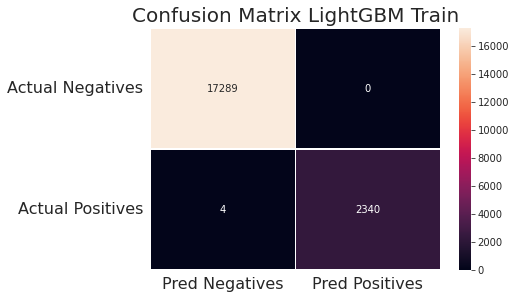

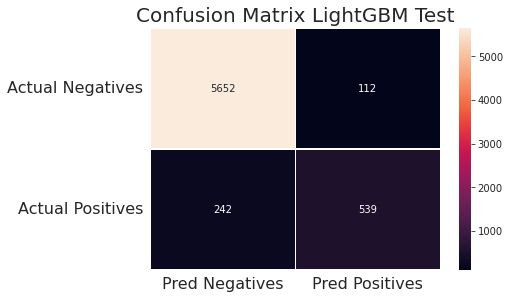

In [114]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(y_train,  model.predict(X_train))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test,  model.predict(X_test))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="43"></a> <br>
### 4.3. ROC Curve

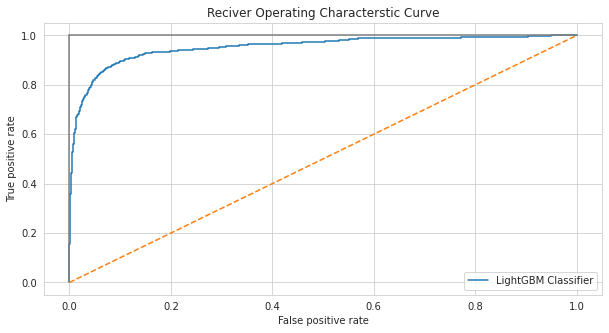

In [115]:
# Obtencion de predicciones para graficar curva ROC
probsdmodel = model.predict_proba(X_test)
predsdmodel = probsdmodel[:,1]

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,predsdmodel)


# Grafico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='LightGBM Classifier')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="44"></a> <br>
### 4.4. Precision-Recall Curve

0.8384929203772711


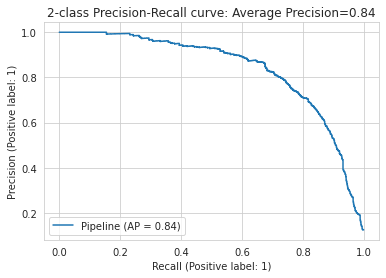

In [116]:
# Curva Precision-Recall
average_precision = average_precision_score(y_test, predsdmodel)

print(average_precision)

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision));

In [117]:


y_true = y_test
y_pred =  model.predict_proba(X_test)[:,1]

scored_df = pd.DataFrame()
scored_df['target'] = y_test
scored_df['1'] = y_pred
scored_df.index = y_true.index
scored_df.sample(2)

# Define paths de y_true, y_pred_proba
#path_y_true = "tmp/test_set.gz"
y_true_col = "target"

#path_y_pred = "tmp/y_pred_proba_lgbm.csv"
y_pred_col = "1"

#id_col = "cus_cust_id_borrower"

# Define función para unificar target y predicción
def get_scored_df(path_y_true, path_y_pred):
    labels = pd.read_csv(path_y_true, usecols=[id_col, y_true_col])
    preds = pd.read_csv(path_y_pred)
    scored = pd.merge(left=labels, right=preds, left_index=True, right_index=True)
    scored[y_pred_col] = scored[y_pred_col].apply(lambda x: round(x*100, 2))
    return scored

# Armado de dataframe scoreado
#scored_df = get_scored_df(path_y_true, path_y_pred)
scored_df.sort_values(y_pred_col, ascending=False, inplace=True, ignore_index=True)
scored_df

# Reemplaza separador decimal
to_hr = lambda x: "{:,}".format(x).replace(",", ".")

# Preprocesamiento del df scoreado + métricas
pps = [round(x, 3) for x in np.arange(0.001, 1.001, 0.001)]
precisions = list()
recalls = list()
kss = list()
msgs_prec = list()
msgs_recall = list()
msgs_ks = list()
total_clientes = scored_df.shape[0]
total_0s = scored_df[y_true_col].value_counts()[0]
total_1s = scored_df[y_true_col].value_counts()[1]
for pp in pps:
    slice_idx = int(total_clientes * pp)
    current_df = scored_df.loc[:slice_idx-1, :]
    try:
      current_0s = current_df[y_true_col].value_counts()[0]
    except:
      current_0s = 0
    try:
      current_1s = current_df[y_true_col].value_counts()[1]
    except:
      current_1s = 0
    precisions.append(current_1s / slice_idx)
    msgs_prec.append("({} de {})".format(to_hr(current_1s), to_hr(slice_idx)))
    gain_1 = current_1s / total_1s
    recalls.append(gain_1)
    msgs_recall.append("({} de {})".format(to_hr(current_1s), to_hr(total_1s)))
    kss.append(gain_1 - (current_0s / total_0s))

# Genera df con métricas
metrics_df = pd.DataFrame({
    "PP": pps,
    "PRECISION": precisions,
    "RECALL": recalls,
    "KS": kss,
    "msg_PRECISION": msgs_prec,
    "msg_RECALL": msgs_recall})

metrics_df

# Calcula métricas
dfs = list()
for c, new_name in [("PRECISION", "PRECISION"),
                    ("RECALL", "RECALL"),
                    ("KS", "KS")]:
    cdf = metrics_df[["PP", c]].copy()
    cdf.rename(columns={c: "VALOR"}, inplace=True)
    cdf["METRICA"] = new_name
    cdf["msg"] = metrics_df["msg_" + c] if c != "KS" else ""
    dfs.append(cdf)
    
# Unifica df scoreado + métricas para plotear
plot_df = pd.concat(dfs)
for c in ["PP", "VALOR"]:
    plot_df[c] = plot_df[c].apply(lambda x: x*100)

# Plotea
fig = px.line(
    plot_df, x="PP", y="VALOR", color="METRICA",
    width=1000, height=700, text=plot_df["msg"],
    hover_data=["METRICA"])

fig.update_layout(
    hovermode="x",
    font_size=15,
    legend_title_text=None,
    paper_bgcolor="rgba(0, 0, 0, 0)",
    title=dict(text="Modelo Conversión TC MLB - Métricas", font_size=25),
    xaxis=dict(range=[0, 100], title=dict(text="Población (ordenada de mayor a menor score)"), dtick=10),
    yaxis=dict(range=[0, 100], title=dict(text="Valor de la métrica"), dtick=10),
    font=dict(color="black"),
    hoverlabel=dict(font_size=16,))

fig.update_traces(mode="lines", hovertemplate="%{y:.1f}% %{text}")
fig.update_xaxes(showspikes=True, spikecolor="gray", spikesnap="cursor", spikemode="across", ticksuffix="%")
fig.update_yaxes(ticksuffix="%")
fig.update_layout(spikedistance=1000, hoverdistance=100)
fig.show()

<a id="42"></a> <br>
### 4.2. Análisis de False Negative

In [124]:
model_predict_proba_train = model.predict_proba(X_train)
model_pred_train = binarize(model_predict_proba_train, threshold = 0.1)[:,1]

model_predict_proba_test = model.predict_proba(X_test)
model_pred_test = binarize(model_predict_proba_test, threshold = 0.1)[:,1]

In [125]:
# recall_score
ftwo_score_train = fbeta_score(y_train, model_pred_train, beta = 2)
print("F2 train = ", ftwo_score_train)
ftwo_score_test = fbeta_score(y_test, model_pred_test, beta = 2)
print("F2 test = ", ftwo_score_test)

F2 train =  0.9775627658687129
F2 test =  0.7997587454764777


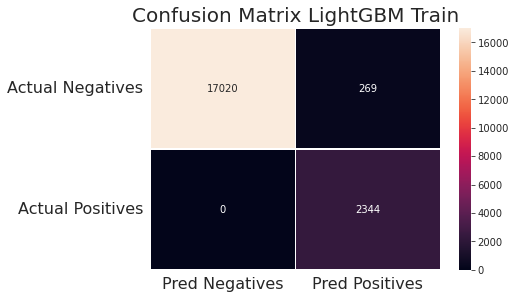

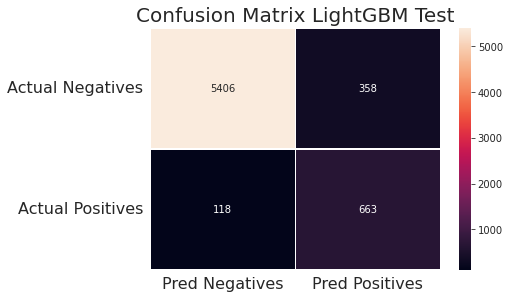

In [126]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(y_train, model_pred_train)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test, model_pred_test)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()